#AKUSISI DATASET

In [1]:
!pip install kaggle

In [2]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 69 bytes


In [3]:
!kaggle datasets download "nicoletacilibiu/movies-and-ratings-for-recommendation-system"

Dataset URL: https://www.kaggle.com/datasets/nicoletacilibiu/movies-and-ratings-for-recommendation-system
License(s): CC0-1.0
  0% 0.00/846k [00:00<?, ?B/s]
100% 846k/846k [00:00<00:00, 1.00GB/s]


In [4]:
!unzip movies-and-ratings-for-recommendation-system.zip

Archive:  movies-and-ratings-for-recommendation-system.zip
  inflating: movies.csv              
  inflating: ratings.csv             


# DATA LOADING

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np

from tensorflow.keras import layers, ops
from tensorflow import keras
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import NearestNeighbors


In [6]:
df_movies = pd.read_csv("movies.csv")
df_ratings = pd.read_csv("ratings.csv")

# EDA

In [7]:
df_movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   int64 
 1   title    9742 non-null   object
 2   genres   9742 non-null   object
dtypes: int64(1), object(2)
memory usage: 228.5+ KB


In [8]:
df_ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


In [9]:
df_ratings['rating'].describe()

,rating
count,100836.000000
mean,3.501557
std,1.042529
min,0.500000
25%,3.000000
50%,3.500000
75%,4.000000
max,5.000000


In [10]:
# Menggabungkan data rating dan film menjadi satu.
df = df_movies.merge(df_ratings, on = 'movieId', how = "left")
df

,movieId,title,genres,userId,rating,timestamp
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1.0,4.0,9.649827e+08
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,5.0,4.0,8.474350e+08
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,7.0,4.5,1.106636e+09
3,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,15.0,2.5,1.510578e+09
4,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,17.0,4.5,1.305696e+09
...,...,...,...,...,...,...
100849,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy,184.0,4.0,1.537109e+09
100850,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy,184.0,3.5,1.537110e+09
100851,193585,Flint (2017),Drama,184.0,3.5,1.537110e+09
100852,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation,184.0,3.5,1.537110e+09


In [11]:
df.duplicated().any()
#Melihat apakah terdapat data yang terduplikasi atau tidak

np.False_

In [12]:
df.isna().sum()
#Untuk melihat apakah terdapat data dengan salah satu kolom atau lebih yang
#merupakan data non angka

,0
movieId,0
title,0
genres,0
userId,18
rating,18
timestamp,18


In [13]:
rating_group = df.groupby(['title', 'rating']).size().reset_index(name='count')
rating_group = rating_group.sort_values(by='count', ascending=False)

avg_rating = df.groupby('title')['rating'].mean().reset_index(name='avg_rating')

rating_group = rating_group.merge(avg_rating, on='title')
rating_group.head(10)

#Melakukan grouping berdasar pada judul dan rating,
#Grouping ini akan diberikan agregasi untuk mencari jumlah review yang diberikan.
# Kemudian akan diberikan rata rata dari rating yang diberikan oleh user.

,title,rating,count,avg_rating
0,"Shawshank Redemption, The (1994)",5.0,153,4.429022
1,Pulp Fiction (1994),5.0,123,4.197068
2,Forrest Gump (1994),5.0,116,4.164134
3,"Matrix, The (1999)",5.0,109,4.192446
4,Star Wars: Episode IV - A New Hope (1977),5.0,104,4.231076
5,"Silence of the Lambs, The (1991)",4.0,97,4.161290
6,Jurassic Park (1993),4.0,97,3.750000
7,Forrest Gump (1994),4.0,94,4.164134
8,Schindler's List (1993),5.0,92,4.225000
9,"Silence of the Lambs, The (1991)",5.0,92,4.161290


In [14]:
df.isna().sum()

,0
movieId,0
title,0
genres,0
userId,18
rating,18
timestamp,18


### Visualisasi

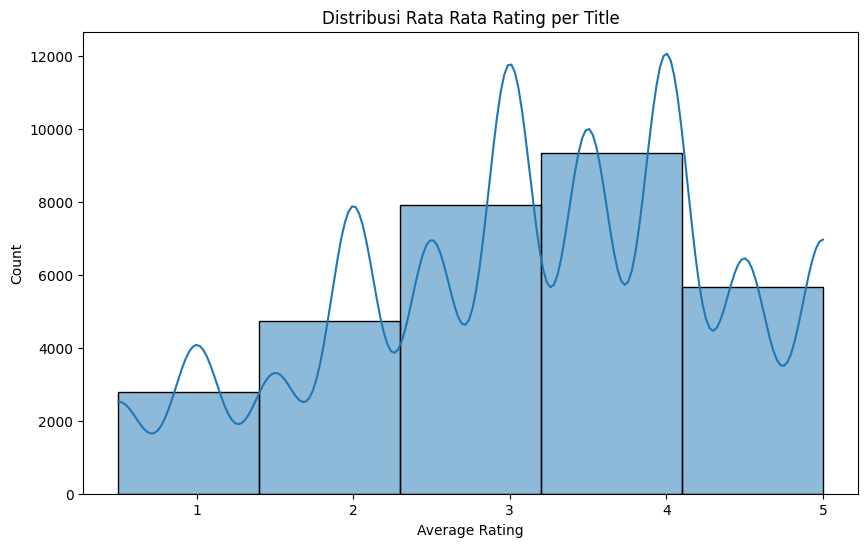

In [15]:
plt.figure(figsize=(10,6))
sns.histplot(rating_group['rating'], bins=5, kde=True)
plt.title('Distribusi Rata Rata Rating per Title')
plt.xlabel('Average Rating')
plt.show()

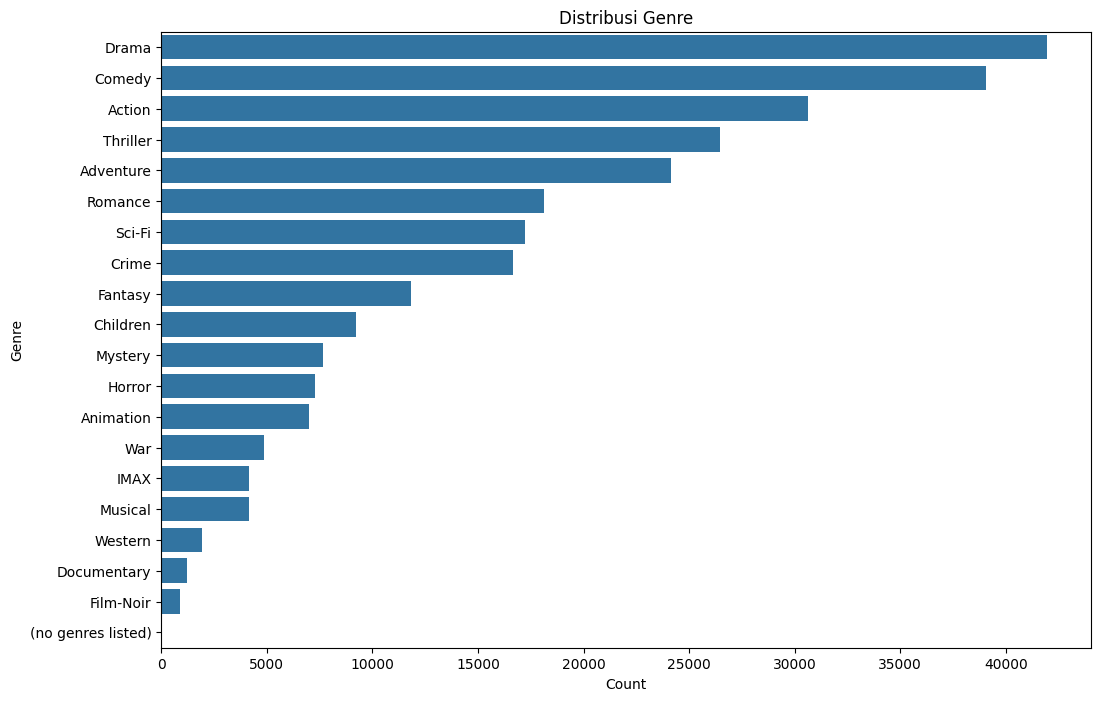

In [16]:
df_genres = df['genres'].str.split('|').explode()

genre_counts = df_genres.value_counts()

plt.figure(figsize=(12,8))
sns.barplot(x=genre_counts.values, y=genre_counts.index)
plt.title('Distribusi Genre')
plt.xlabel('Count')
plt.ylabel('Genre')
plt.show()


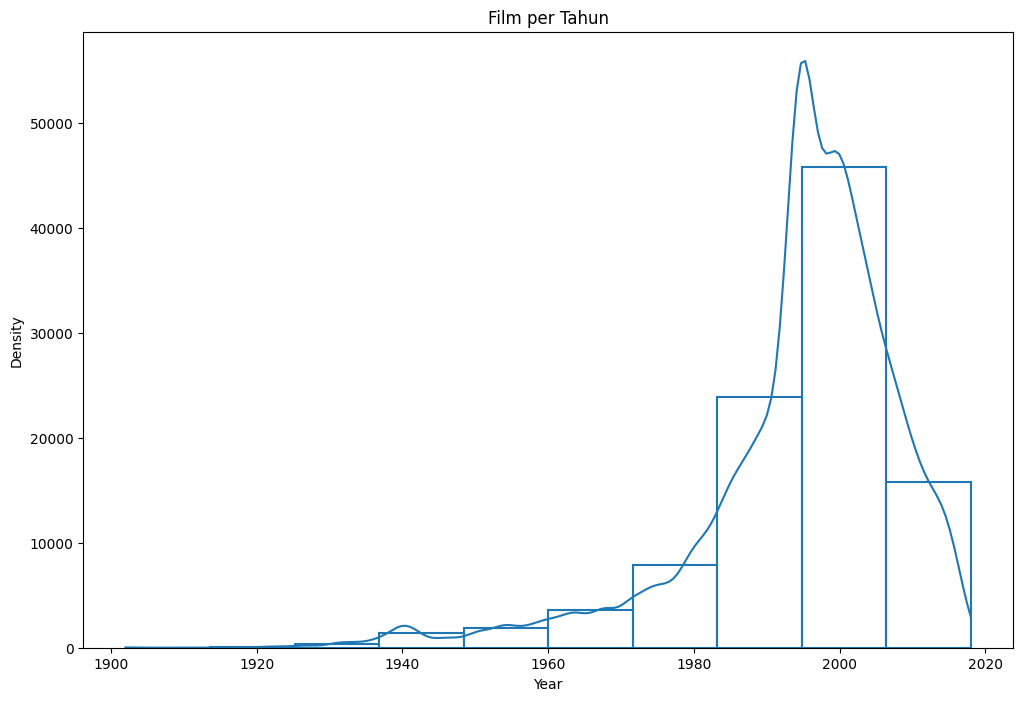

In [17]:
# Ekstrak tahun
df['year'] = df['title'].str.extract(r'\((\d{4})\)').astype(float)
plt.figure(figsize=(12,8))

# Hilangkan tahun yang hilang
years = df['year'].dropna()

# Plot histogram dengan KDE
sns.histplot(years, bins=10, kde=True, fill = False)

plt.title('Film per Tahun')
plt.xlabel('Year')
plt.ylabel('Density')
plt.show()

## Insight
Dalam graph yang telah di buat, terdapat beberapa insight yang didapatkan.

- Dataset ini memiliki film yang dimulai sekitar tahun 1900 awal hingga pada sebelum tahun 2020 (sekitar tahun 2018).
- Dari dataset tersebut, dapat dilihat bahwa film yang paling banyak direview oleh pengguna adalah film dari tahun sekitar 1990 hingga pada tahun 2020, dengan puncaknya ada disekitar tahun 200-an
- Genre yang paling sering ditonton oleh pengguna adalah genre Drama. Diikuti dengan Komedi, Action, Adventure, Romance, Scifi, dan Crime. Kita mungkin akan sering mendapatkan rekomendasi yang berkisar pada genre ini.
- User cenderung memberikan rating sekitar 2.5 hingga 4.3.

# Preprocessing

## Missing Value dan Duplicated

Di tahap ini, jika memang ada nilai yang kosong dan juga nilai duplikat, maka akan dilakukan sebuah treatment terhadap dataset yang ada.
Pandas sendiri telah memberikan tools bawaan untuk melakukan hal tersebut.

Yakni:

`dropna()` untuk menghapus nilai yang kosong

`drop_duplicates()` untuk menghapus nilai yang duplikat



In [18]:
df = df.dropna()
#Potonga ini berguna untuk menghapus data yang memiliki kolom kosong dalam baris tersebut

In [19]:
df = df.drop_duplicates()
#Potongan Ini berguna untuk menghapus data yang duplikat

# Preparasi Untuk Content-Based Collaboration

## Embedding
Embed setiap genre dengan tfid.

Ini dilakukan untuk mengubah untuk mengubah setiap huruf menjadi angka dengan nilai kepentingannya yang disesuaikan pada corpus yang kita miliki.

In [20]:
tfidf_vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf_vectorizer.fit_transform(df['genres'])
tfidf_vectorizer.get_feature_names_out()

#Melakukan embed, kemudian dilakukan pengecekan, fitur apa saja yang didapat
#melalui proses embedding tersebut.

array(['action', 'adventure', 'animation', 'children', 'comedy', 'crime',
       'documentary', 'drama', 'fantasy', 'fi', 'film', 'genres',
       'horror', 'imax', 'listed', 'musical', 'mystery', 'noir',
       'romance', 'sci', 'thriller', 'war', 'western'], dtype=object)

## Calculate Distance
Pengukuran kesamaan menggunakan cosinus

In [21]:
n_neighbors = 6
nn_model = NearestNeighbors(n_neighbors=n_neighbors, metric='cosine', algorithm='brute')
nn_model.fit(tfidf_matrix)

#Dikarenakan colab memiliki memory yang terbatas, dan menggunakan pearson corelation dan
#Cosine Similarity Function akan membuat muat ram yang berlebihan, maka disini kita
#akan emnggunakan nearest neighbors dengan algoritma brute force dan pendekatan cosine
#distance untuk mencari nilai jarak kosinus

NearestNeighbors(algorithm='brute', metric='cosine', n_neighbors=6)

In [22]:
distances, indices = nn_model.kneighbors(tfidf_matrix)
similarities = 1 - distances

#Menghitung kemiripan dengan menggunakan hasil dari fitting model

## Preparasi Untuk Collaborative Learning

In [23]:
user_ids = df["userId"].unique().tolist()
movie_ids = df["movieId"].unique().tolist()
#Mengambil id user dan juga film yang memang unik, untuk memastikan tidak adanya
#nilai yang terduplikasi.
#Nilai id yang telah diambil tadi di ubah menjadi List.

Melakukan encode agar lebih mudah dimasukkan ke model

Ini akan menghasilkan nilai dari yang seperti:

[123,321,223]

menjadi:

[1,2,3]

In [24]:
user_idx = {x: i for i, x in enumerate(user_ids)}
movie_idx = {x: i for i, x in enumerate(movie_ids)}
#Melakukan mapping untuk di aplikasikan terhadap indexing dataset

movie_decoded = {i : x for i, x in enumerate(movie_ids)}  #mengubah kembali, untuk inferencing

df["userIdx"] = df["userId"].map(user_idx)
df["movieIdx"] = df["movieId"].map(movie_idx)
#Mengaplikasi map yang telah di buat.

In [25]:
df["rating"] = df["rating"].values.astype(np.float32) # konversi menjadi float

In [26]:
#minmax scaling
min_rating = min(df["rating"])
max_rating = max(df["rating"])

# Mengambil jumlah user dan film
num_users = len(user_idx)
num_movies = len(movie_idx)

In [27]:
print('Lowest Rating | Max Rating: ', end = "")
print(min_rating,"|",max_rating)
print("Num Users | Num Movies: ", end = "")
print(num_users, "|",num_movies)

Lowest Rating | Max Rating: 0.5 | 5.0
Num Users | Num Movies: 610 | 9711


In [28]:
#Shuffle/Kocok dataset
df = df.sample(frac=1, random_state=42)
df

,movieId,title,genres,userId,rating,timestamp,year,userIdx,movieIdx
36719,1923,There's Something About Mary (1998),Comedy|Romance,263.0,4.0,9.403846e+08,1998.0,92,1403
40180,2134,Weird Science (1985),Comedy|Fantasy|Sci-Fi,387.0,2.5,1.095041e+09,1985.0,336,1591
49900,2959,Fight Club (1999),Action|Crime|Drama|Thriller,211.0,5.0,1.350913e+09,1999.0,468,2224
6187,230,Dolores Claiborne (1995),Drama|Thriller,414.0,3.0,9.615180e+08,1995.0,146,196
12080,434,Cliffhanger (1993),Action|Adventure|Thriller,353.0,3.0,8.319397e+08,1993.0,127,378
...,...,...,...,...,...,...,...,...,...
6265,231,Dumb & Dumber (Dumb and Dumber) (1994),Adventure|Comedy,353.0,4.0,8.319397e+08,1994.0,127,197
54890,3499,Misery (1990),Drama|Horror|Thriller,599.0,2.5,1.498515e+09,1990.0,204,2610
76830,8670,"Testament of Dr. Mabuse, The (Das Testament de...",Crime|Horror|Mystery|Thriller,387.0,4.0,1.179200e+09,1933.0,336,5262
860,15,Cutthroat Island (1995),Action|Adventure|Romance,6.0,4.0,8.455545e+08,1995.0,215,14


## Membagi dataset

Disini, akan dilakukan pembagian dataset dengan scaling menggunakan minmax scaler, kemudian dataset akan di pecah dengan skala

90%10



In [29]:
x = df[["userIdx", "movieIdx"]].values
y = df["rating"].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values
#Splice dataste
split = int(0.9 * df.shape[0])
x_train, x_val, x_test, y_train, y_val, y_test = (x[:split], x[split:], x[:split], y[:split], y[split:], y[split:])

# Training

# Content Based / System

In [30]:
def recommend(movie_index, df, indices, similarities):
    print(f"Original Movie: {df.iloc[movie_index]['title']} {df.iloc[movie_index]['genres']}\n")
    print("Top Recommendations:")
    amt_recommend = len(indices[movie_index])
    sims = similarities[movie_index]
    rec_df = pd.DataFrame(columns=['idx', 'movie_id', 'title', 'genres', 'rating', 'similarity Score'])
    for i in range(1, amt_recommend): #Loop hingga jumlah yang di klasifikasikan sesuai pada jumlah film yang di dapatkan di similarity index similarity test
        idx = indices[movie_index][i]
        movie_id = df.iloc[idx]['movieId']
        title = df.iloc[idx]['title']
        rating = df.iloc[idx]['rating']
        genre = df.iloc[idx]['genres']
        similarity_score = similarities[movie_index][i]
        rec_df.loc[i] = [idx, movie_id, title, genre, rating, similarity_score]

    return rec_df

In [31]:
def calculate_precision(movie_index, df, indices, top_n_recommendations=10):
    # Ambil genre
    target_genres = set(df.loc[movie_index, 'genres'].split('|'))

    # Ambil nilai neighbors
    neighbor_indices = indices[movie_index][1:top_n_recommendations + 1]

    # Hmenghitung berapa banyak rekomendasi film yang memiliki kemiripan genre dengan film target.
    relevant_count = 0
    for i in neighbor_indices:
        candidate_genres = set(df.loc[i, 'genres'].split('|'))
        if target_genres & candidate_genres:
            relevant_count += 1

    precision = relevant_count / top_n_recommendations
    return precision


## Melakukan Percobaan atau Inferencing
Di tahapan ini, system yang di bangun akan di test.

In [32]:
x = recommend(123, df, indices, similarities)
x

Original Movie: Untouchables, The (1987) Action|Crime|Drama

Top Recommendations:


,idx,movie_id,title,genres,rating,similarity Score
1,64064,31658,Howl's Moving Castle (Hauru no ugoku shiro) (2...,Adventure|Animation|Fantasy|Romance,4.0,1.0
2,64065,2064,Roger & Me (1989),Documentary,5.0,1.0
3,64034,2421,"Karate Kid, Part II, The (1986)",Action|Adventure|Drama,2.0,1.0
4,64035,92535,Louis C.K.: Live at the Beacon Theater (2011),Comedy,4.5,1.0
5,64036,2011,Back to the Future Part II (1989),Adventure|Comedy|Sci-Fi,3.5,1.0


In [33]:
precision = calculate_precision(
    movie_index=123,
    df=df,
    indices=indices,
    top_n_recommendations=5
)

print(f"Genre-based Precision@5 untuk index 123: {precision:.2f}")


Genre-based Precision@5 untuk index 123: 1.00


Dalam percobaan ini, kita mendapat 4 film yang direkomendasikan.


Bila diperhatikan, seluruh film ini tidak memiliki hubungan langsung dengan film Untouchables, ini merupakan nilai yang diekspektasikan karena ketika menggunakan tfidf, yang diperhatikan hanyalaah hubungan 1 kalimat ke kalimat yang lain.

# Collaborative Filtering

Membangun custom model menggunakan keras.

In [34]:
class RecommenderNet(keras.Model):
    def __init__(self, num_users, num_movies, embedding_size, **kwargs):
        super().__init__(**kwargs)
        self.num_users = num_users #berapa banyak user?
        self.num_movies = num_movies #berapa banyak film?
        self.embedding_size = embedding_size #Seberapa besar embedding akan dilakukan?
        self.user_embedding = layers.Embedding(
            num_users,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        ) #melakukan embedding terhadap user menjadi nilai vector
        self.user_bias = layers.Embedding(num_users, 1) #menambah bias untuk nilai user
        self.movie_embedding = layers.Embedding(
            num_movies,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        ) #melakukan embedding terhadap film menjadi nilai vektor
        self.movie_bias = layers.Embedding(num_movies, 1) #menentukan bias untuk film

    def call(self, inputs):
        user_vector = self.user_embedding(inputs[:, 0])
        user_bias = self.user_bias(inputs[:, 0])
        movie_vector = self.movie_embedding(inputs[:, 1])
        movie_bias = self.movie_bias(inputs[:, 1])
        # Mencari dot products melalui perkalian matriks
        dot_user_movie = ops.tensordot(user_vector, movie_vector, 2)
        # kemudian menambah bias
        x = dot_user_movie + user_bias + movie_bias
        # Hitung nilai aktivasinya
        return ops.nn.sigmoid(x)


model = RecommenderNet(num_users, num_movies, 50)
model.compile(
    loss=keras.losses.BinaryCrossentropy(),
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
)


In [35]:
history = model.fit(
    x=x_train,
    y=y_train,
    batch_size=32,
    epochs=15,
    verbose=1,
    validation_data=(x_val, y_val),
)

# Melakukan fitting
# dengan 15 epochs dan 32 batch size


Epoch 1/15
2836/2836 ━━━━━━━━━━━━━━━━━━━━ 24s 8ms/step - loss: 0.6529 - val_loss: 0.6148
Epoch 2/15
2836/2836 ━━━━━━━━━━━━━━━━━━━━ 23s 8ms/step - loss: 0.6116 - val_loss: 0.6094
Epoch 3/15
2836/2836 ━━━━━━━━━━━━━━━━━━━━ 23s 8ms/step - loss: 0.6077 - val_loss: 0.6072
Epoch 4/15
2836/2836 ━━━━━━━━━━━━━━━━━━━━ 23s 8ms/step - loss: 0.6035 - val_loss: 0.6063
Epoch 5/15
2836/2836 ━━━━━━━━━━━━━━━━━━━━ 41s 8ms/step - loss: 0.6040 - val_loss: 0.6049
Epoch 6/15
2836/2836 ━━━━━━━━━━━━━━━━━━━━ 40s 8ms/step - loss: 0.6017 - val_loss: 0.6055
Epoch 7/15
2836/2836 ━━━━━━━━━━━━━━━━━━━━ 41s 8ms/step - loss: 0.6009 - val_loss: 0.6065
Epoch 8/15
2836/2836 ━━━━━━━━━━━━━━━━━━━━ 41s 8ms/step - loss: 0.6007 - val_loss: 0.6051
Epoch 9/15
2836/2836 ━━━━━━━━━━━━━━━━━━━━ 23s 8ms/step - loss: 0.6020 - val_loss: 0.6061
Epoch 10/15
2836/2836 ━━━━━━━━━━━━━━━━━━━━ 40s 8ms/step - loss: 0.6016 - val_loss: 0.6057
Epoch 11/15
2836/2836 ━━━━━━━━━━━━━━━━━━━━ 22s 8ms/step - loss: 0.6004 - val_loss: 0.6056
Epoch 12/15
2836/28

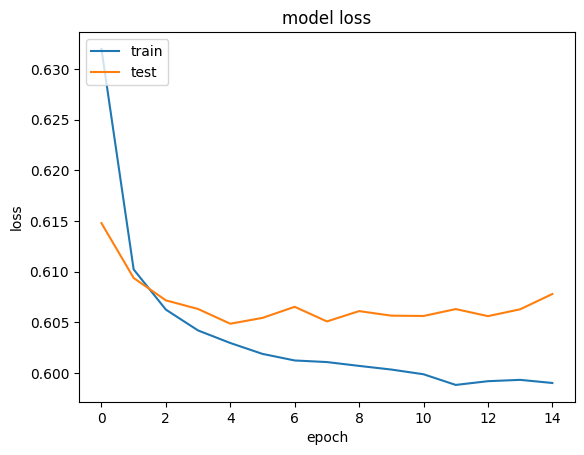

In [36]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()

## Hasil
Melihat pada hasil, model tidak mengalami overfit, dan memiliki hasil yang cukup baik

# **Inferencing** || **Collaborative Learning**

In [38]:
df.columns

Index(['movieId', 'title', 'genres', 'userId', 'rating', 'timestamp', 'year',
       'userIdx', 'movieIdx'],
      dtype='object')

In [39]:
# Mengambil Data User
user_id = 524

#mengambil film yang telah di nonton oleh user
movies_watched_by_user = df[df.userId == user_id]

#mengambil film yang belum ditonton oleh user
movies_not_watched = df_movies[~df_movies["movieId"].isin(movies_watched_by_user.movieId.values)]["movieId"]

#Membuatnya menjadi list unique
movies_not_watched = list(set(movies_not_watched).intersection(set(movie_idx.keys())))

# Mengambil index movie
movies_not_watched = [[movie_idx.get(x)] for x in movies_not_watched]
#mengambil index user
user_encoder = user_idx.get(user_id)

#menggabungkan index user dan film yang belum ditontonnya dan ditumpuk secara horizontal
user_movie_array = np.hstack(([[user_encoder]] * len(movies_not_watched), movies_not_watched))

In [40]:
print(f"id: {user_id}")
movies_watched_by_user[movies_watched_by_user['rating'] >= 4].sample(5)

id: 524


,movieId,title,genres,userId,rating,timestamp,year,userIdx,movieIdx
7067,260,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Sci-Fi,524.0,5.0,851609016.0,1977.0,179,224
25361,1200,Aliens (1986),Action|Adventure|Horror|Sci-Fi,524.0,5.0,851609623.0,1986.0,179,901
27116,1231,"Right Stuff, The (1983)",Drama,524.0,4.0,851609597.0,1983.0,179,930
27794,1250,"Bridge on the River Kwai, The (1957)",Adventure|Drama|War,524.0,4.0,851609597.0,1957.0,179,948
28711,1270,Back to the Future (1985),Adventure|Comedy|Sci-Fi,524.0,5.0,851609356.0,1985.0,179,968


Bila diperhatikan, film yang di sukai oleh pengguna 524 adalah yang bergenre drama, dan thriller/mysteries, dengan mayoritasnya adalah Drama.

In [41]:
ratings = model.predict(user_movie_array).flatten()

top_ratings_indices = ratings.argsort()[-10:][::-1] #mengambil rekomendasi 10 film terbaik
recommended_movie_ids = [
    movie_decoded.get(movies_not_watched[x][0]) for x in top_ratings_indices
]

print("User Sample: {}".format(user_id))
print("====" * 9)
print("Film dengan penilaian tinggi dri user")
print("----" * 8)
top_movies_user = (
    movies_watched_by_user.sort_values(by="rating", ascending=False)
    .head(5)
    .movieId.values
) #mengambil 5 film dengan rating terbaik yang diberikan user
movie_df_rows = df_movies[df_movies["movieId"].isin(top_movies_user)]
for row in movie_df_rows.itertuples():
    print(row.title, ":", row.genres)

print("----" * 8)
print("10 rekomendasi film yang akan di ambil")
print("----" * 8)
recommended_movies = df_movies[df_movies["movieId"].isin(recommended_movie_ids)]
for row in recommended_movies.itertuples():
    print(row.title, ":", row.genres)


300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
User Sample: 524
Film dengan penilaian tinggi dri user
--------------------------------
Apollo 13 (1995) : Adventure|Drama|IMAX
Rob Roy (1995) : Action|Drama|Romance|War
Star Wars: Episode IV - A New Hope (1977) : Action|Adventure|Sci-Fi
Princess Bride, The (1987) : Action|Adventure|Comedy|Fantasy|Romance
Indiana Jones and the Last Crusade (1989) : Action|Adventure
--------------------------------
10 rekomendasi film yang akan di ambil
--------------------------------
Hoop Dreams (1994) : Documentary
Heavenly Creatures (1994) : Crime|Drama
Streetcar Named Desire, A (1951) : Drama
Paths of Glory (1957) : Drama|War
Lawrence of Arabia (1962) : Adventure|Drama|War
Goodfellas (1990) : Crime|Drama
Ran (1985) : Drama|War
Life Is Beautiful (La Vita è bella) (1997) : Comedy|Drama|Romance|War
There Will Be Blood (2007) : Drama|Western
Separation, A (Jodaeiye Nader az Simin) (2011) : Drama


## Kesimpulan Hasil
Bila diperhatikan, mayoritas daripada rekomendasinya adalah film Drama.

Ini sesuai dengan hipotesis awal, dimana akan sering ditemukan rekomendasi dengan genre Drama.